In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip3 install torch torchvision pandas transformers scikit-learn tensorflow numpy seaborn matplotlib textwrap3

In [3]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
import transformers
from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup
import torch
from torchvision import transforms
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image


def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9_]+", ' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.,!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)
    return text

def label_to_target(text):
  if text == "informative":
    return 1
  else:
    return 0

df_train = pd.read_csv("./gdrive/MyDrive/ColabNotebooks/train.tsv", sep='\t')
df_train = df_train[['image', 'tweet_text', 'label_text']]
df_train = df_train.sample(frac=1, random_state = 24).reset_index(drop=True)
df_train['tweet_text'] = df_train['tweet_text'].apply(clean_text)
df_train['label_text'] = df_train['label_text'].apply(label_to_target)

df_val = pd.read_csv("./gdrive/MyDrive/ColabNotebooks/val.tsv", sep='\t')
df_val = df_val[['image', 'tweet_text', 'label_text']]
df_val = df_val.sample(frac=1, random_state = 24).reset_index(drop=True)
df_val['tweet_text'] = df_val['tweet_text'].apply(clean_text)
df_val['label_text'] = df_val['label_text'].apply(label_to_target)

df_test = pd.read_csv("./gdrive/MyDrive/ColabNotebooks/test.tsv", sep='\t')
df_test = df_test[['image', 'tweet_text', 'label_text']]
df_test = df_test.sample(frac=1, random_state = 24).reset_index(drop=True)
df_test['tweet_text'] = df_test['tweet_text'].apply(clean_text)
df_test['label_text'] = df_test['label_text'].apply(label_to_target)


In [5]:
data_dir = "./gdrive/MyDrive/"
class DisasterTweetDataset(Dataset):

  def __init__(self, tweets, targets, paths, tokenizer, max_len):
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.paths = paths
    self.transform = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
  
  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    target = self.targets[item]
    path = str(self.paths[item])
    img = Image.open(data_dir+self.paths[item]).convert('RGB')
    img = self.transform(img)  

    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation = True
    )

    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long),
      'tweet_image': img
    }

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = DisasterTweetDataset(
    tweets=df.tweet_text.to_numpy(),
    targets=df.label_text.to_numpy(),
    paths=df.image.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )


class TweetClassifier(nn.Module):

  def __init__(self):
    super(TweetClassifier, self).__init__()
    self.roberta = RobertaModel.from_pretrained("roberta-base")
    for param in self.roberta.parameters():
      param.requires_grad = False
    
    self.resnext = torchvision.models.resnext50_32x4d(pretrained=True)
    for param in self.resnext.parameters():
      param.requires_grad = False
    
    self.bn = nn.BatchNorm1d(self.roberta.config.hidden_size + 1000)

    self.linear1 = nn.Linear(self.roberta.config.hidden_size + 1000, 1000)
    self.relu1    = nn.ReLU()
    self.dropout1 = nn.Dropout(p=0.4)

    self.linear2 = nn.Linear(1000, 500)
    self.relu2    = nn.ReLU()
    self.dropout2 = nn.Dropout(p=0.2)

    self.linear3 = nn.Linear(500, 250)
    self.relu3    = nn.ReLU()
    self.dropout3 = nn.Dropout(p=0.1)

    self.linear4 = nn.Linear(250, 125)
    self.relu4    = nn.ReLU()
    self.dropout4 = nn.Dropout(p=0.02)

    self.linear5 = nn.Linear(125, 1)
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, input_ids, attention_mask, tweet_img):
    output = self.roberta(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = output[0]
    text_output = torch.mean(output, 1)

    image_output = self.resnext(tweet_img)
    merged_output = torch.cat((text_output, image_output), dim=1)
    bn_output = self.bn(merged_output)

    linear1_output = self.linear1(bn_output)
    relu1_output = self.relu1(linear1_output)
    dropout1_output = self.dropout1(relu1_output)

    linear2_output = self.linear2(dropout1_output)
    relu2_output = self.relu2(linear2_output)
    dropout2_output = self.dropout2(relu2_output)

    linear3_output = self.linear3(dropout2_output)
    relu3_output = self.relu3(linear3_output)
    dropout3_output = self.dropout3(relu3_output)

    linear4_output = self.linear4(dropout3_output)
    relu4_output = self.relu4(linear4_output)
    dropout4_output = self.dropout4(relu4_output)

    linear5_output = self.linear5(dropout4_output)


    probas = self.sigmoid(linear5_output)
    return probas


def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    tweet_imgs = d["tweet_image"].to(device)
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].reshape(-1, 1).float()
    targets = targets.to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      tweet_img = tweet_imgs
    )


    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(torch.round(outputs) == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      tweet_imgs = d["tweet_image"].to(device)
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].reshape(-1, 1).float()
      targets = targets.to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        tweet_img = tweet_imgs
      )

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(torch.round(outputs) == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
BATCH_SIZE = 512
MAX_LEN = 150

PRE_TRAINED_MODEL_NAME = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


model = TweetClassifier()
model = model.to(device)

EPOCHS = 50

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.BCELoss().to(device)

In [7]:
history = defaultdict(list)
start_epoch = 0
best_accuracy = -1

# checkpoint = torch.load("./gdrive/MyDrive/Models/RobertaResnext/checkpoint.t7")
# model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# start_epoch = checkpoint['epoch']
# best_accuracy = checkpoint['best_accuracy']

# print(start_epoch)
# print(best_accuracy)


for epoch in range(EPOCHS):

  print(f'Epoch {start_epoch + epoch + 1}/{start_epoch + EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    state = {
            'best_accuracy': val_acc,
            'epoch': start_epoch+epoch+1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
    }
    savepath= "./gdrive/MyDrive/Models/RobertaResnext/checkpoint.t7"
    torch.save(state,savepath)
    best_accuracy = val_acc

Epoch 1/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.6280071296189961 accuracy 0.6673263201749817
Val   loss 0.5288203358650208 accuracy 0.7476160203432931

Epoch 2/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.4343449928258595 accuracy 0.8182480991563379
Val   loss 0.39538925141096115 accuracy 0.8207247298156389

Epoch 3/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.3229427651355141 accuracy 0.8659514633892302
Val   loss 0.33257097750902176 accuracy 0.856325492689129

Epoch 4/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.287426485042823 accuracy 0.8786584730757212
Val   loss 0.3301216661930084 accuracy 0.8556897647806739

Epoch 5/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2681947852435865 accuracy 0.887511717529424
Val   loss 0.327856220304966 accuracy 0.8626827717736809

Epoch 6/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2497420624682778 accuracy 0.8982397666909696
Val   loss 0.3280169889330864 accuracy 0.8626827717736809

Epoch 7/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.237962638076983 accuracy 0.901572752838246
Val   loss 0.3283008113503456 accuracy 0.8677685950413223

Epoch 8/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2301978986514242 accuracy 0.906468076242058
Val   loss 0.328991562128067 accuracy 0.8671328671328672

Epoch 9/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2226677866358506 accuracy 0.9109467763774607
Val   loss 0.3260311782360077 accuracy 0.8696757787666879

Epoch 10/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.21702118688508085 accuracy 0.9146963857931465
Val   loss 0.32704176753759384 accuracy 0.870311506675143

Epoch 11/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.20731469831968607 accuracy 0.9174044370378085
Val   loss 0.3284630700945854 accuracy 0.8690400508582327

Epoch 12/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.19990585116963638 accuracy 0.9242787209665659
Val   loss 0.3327144384384155 accuracy 0.8715829624920534

Epoch 13/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.19578229518313156 accuracy 0.9228205395271326
Val   loss 0.3338182643055916 accuracy 0.8722186904005086

Epoch 14/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.18802210453309512 accuracy 0.925111967503385
Val   loss 0.33380505442619324 accuracy 0.8773045136681501

Epoch 15/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.18501294051346026 accuracy 0.9261535256744089
Val   loss 0.33755894005298615 accuracy 0.8753973299427845

Epoch 16/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.1740478802668421 accuracy 0.9329236537860639
Val   loss 0.34298175573349 accuracy 0.8741258741258742

Epoch 17/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.1714645443778289 accuracy 0.9350067701281116
Val   loss 0.3435495048761368 accuracy 0.8773045136681501

Epoch 18/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.16597015214593788 accuracy 0.9341735235912926
Val   loss 0.3391142189502716 accuracy 0.8811188811188811

Epoch 19/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.16427057354073776 accuracy 0.9364649515675451
Val   loss 0.34507307410240173 accuracy 0.8773045136681501

Epoch 20/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.15954658624372983 accuracy 0.9409436517029476
Val   loss 0.34818198531866074 accuracy 0.8779402415766052

Epoch 21/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.15564615161795364 accuracy 0.9395896260806166
Val   loss 0.3499988690018654 accuracy 0.8785759694850604

Epoch 22/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.15301840791576787 accuracy 0.9413602749713571
Val   loss 0.3524986729025841 accuracy 0.8785759694850604

Epoch 23/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.14841750028886294 accuracy 0.943755858764712
Val   loss 0.3573068305850029 accuracy 0.8773045136681501

Epoch 24/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.14292243828898982 accuracy 0.9488594938027288
Val   loss 0.3630445823073387 accuracy 0.8779402415766052

Epoch 25/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.14184062104476125 accuracy 0.947817935631705
Val   loss 0.36167050153017044 accuracy 0.8773045136681501

Epoch 26/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.14058648128258555 accuracy 0.9474013123632955
Val   loss 0.3680962324142456 accuracy 0.8753973299427845

Epoch 27/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.13824564336161865 accuracy 0.947817935631705
Val   loss 0.37395837903022766 accuracy 0.8741258741258742

Epoch 28/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.13263365391053653 accuracy 0.9509426101447765
Val   loss 0.3736078515648842 accuracy 0.8760330578512396

Epoch 29/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.13276180821029762 accuracy 0.9519841683158005
Val   loss 0.3743208199739456 accuracy 0.8773045136681501

Epoch 30/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.13073237985372543 accuracy 0.9500052077908551
Val   loss 0.37585942447185516 accuracy 0.8753973299427845

Epoch 31/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.12371444310012616 accuracy 0.9550046870117695
Val   loss 0.38090160489082336 accuracy 0.8741258741258742

Epoch 32/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.1253750202687163 accuracy 0.9538589730236433
Val   loss 0.38610774278640747 accuracy 0.8722186904005086

Epoch 33/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.12597218587210304 accuracy 0.9542755962920528
Val   loss 0.3862464725971222 accuracy 0.8722186904005086

Epoch 34/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.1182980278604909 accuracy 0.9546922195604625
Val   loss 0.38888130336999893 accuracy 0.8728544183089638

Epoch 35/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.12004757123558145 accuracy 0.9560462451827935
Val   loss 0.3886600434780121 accuracy 0.8728544183089638

Epoch 36/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.11920268480714999 accuracy 0.9576085824393292
Val   loss 0.3900262489914894 accuracy 0.8709472345835982

Epoch 37/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.12138321760453676 accuracy 0.9538589730236433
Val   loss 0.3934808373451233 accuracy 0.8715829624920534

Epoch 38/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.11928746731657731 accuracy 0.9542755962920528
Val   loss 0.39796996861696243 accuracy 0.8734901462174189

Epoch 39/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.11560276542839251 accuracy 0.9583376731590459
Val   loss 0.3905828967690468 accuracy 0.8741258741258742

Epoch 40/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.11495071845619302 accuracy 0.9580252057077387
Val   loss 0.39686527103185654 accuracy 0.8715829624920534

Epoch 41/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.11485142574498527 accuracy 0.9565670242683053
Val   loss 0.4013626500964165 accuracy 0.8722186904005086

Epoch 42/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.11027583283813376 accuracy 0.9601083220497865
Val   loss 0.40274444967508316 accuracy 0.8734901462174189

Epoch 43/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.11236905581072758 accuracy 0.9594833871471722
Val   loss 0.3999132812023163 accuracy 0.8734901462174189

Epoch 44/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.11368371428627717 accuracy 0.9599000104155817
Val   loss 0.3989999294281006 accuracy 0.8734901462174189

Epoch 45/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.11317870961992364 accuracy 0.9604207895010936
Val   loss 0.4003702700138092 accuracy 0.8734901462174189

Epoch 46/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.10752399697115547 accuracy 0.962399750026039
Val   loss 0.40220097452402115 accuracy 0.8734901462174189

Epoch 47/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.10909018234202736 accuracy 0.9617748151234247
Val   loss 0.40467624366283417 accuracy 0.8741258741258742

Epoch 48/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.11025385950741015 accuracy 0.9601083220497865
Val   loss 0.4044693186879158 accuracy 0.8734901462174189

Epoch 49/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.10993690435823641 accuracy 0.9597958545984793
Val   loss 0.40351833403110504 accuracy 0.8741258741258742

Epoch 50/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.10541149777801413 accuracy 0.9625039058431413
Val   loss 0.40327971428632736 accuracy 0.8734901462174189



In [8]:
state = {
        'epoch': start_epoch + EPOCHS,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
}
savepath= "./gdrive/MyDrive/Models/RobertaResnext/checkpoint-{}.t7".format(start_epoch + EPOCHS)
torch.save(state,savepath)

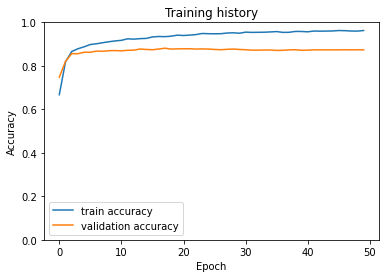

In [9]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [10]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  predictions = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      input_ids = d["input_ids"].to(device)
      tweet_imgs = d["tweet_image"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].reshape(-1, 1).float()
      targets = targets.to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        tweet_img = tweet_imgs
      )
      preds = torch.round(outputs)


      predictions.extend(preds)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, real_values

y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

print(classification_report(y_test, y_pred, target_names=['Not Informative', 'Informative'], digits=4))

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


                 precision    recall  f1-score   support

Not Informative     0.8779    0.7421    0.8043       504
    Informative     0.8827    0.9495    0.9149      1030

       accuracy                         0.8814      1534
      macro avg     0.8803    0.8458    0.8596      1534
   weighted avg     0.8811    0.8814    0.8785      1534

